In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values 
y_iris = iris.target

In [3]:
print(X_iris.shape, y_iris.shape)

(150, 2) (150,)


In [4]:
print(X_iris[:5,:])
print(y_iris[:5])

[[1.4 0.2]
 [1.4 0.2]
 [1.3 0.2]
 [1.5 0.2]
 [1.4 0.2]]
0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64


In [5]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [6]:
export_graphviz( tree_clf,
out_file="iris_tree.dot",
feature_names=["petal length (cm)", "petal width (cm)"], class_names=iris.target_names,
rounded=True,
filled=True
)

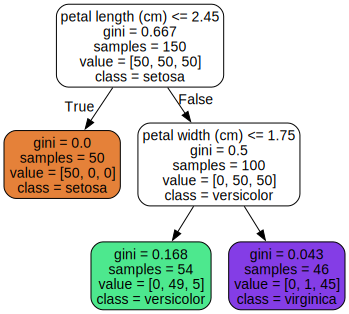

In [7]:
from graphviz import Source 
Source.from_file("iris_tree.dot")

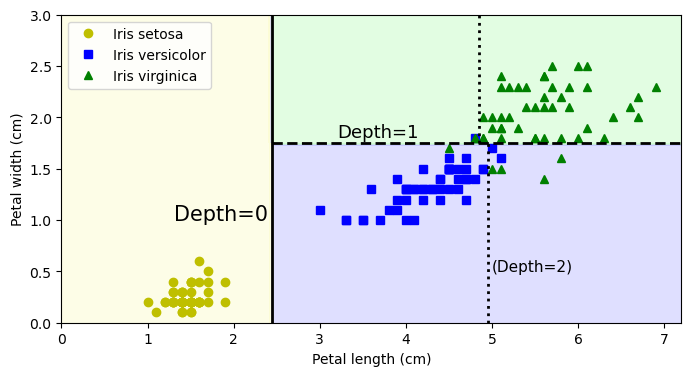

In [8]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()

plt.show()

In [9]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [10]:
tree_clf.predict([[5, 1.5]])

array([1])

In [11]:
pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42) 
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [12]:
export_graphviz( tree_clf_pca,
out_file="iris_tree_pca.dot",
feature_names=["petal length (cm)", "petal width (cm)"], class_names=iris.target_names,
rounded=True,
filled=True
)

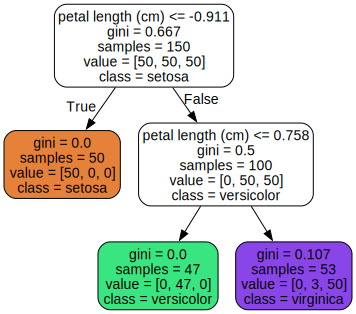

In [13]:
Source.from_file("iris_tree_pca.dot")

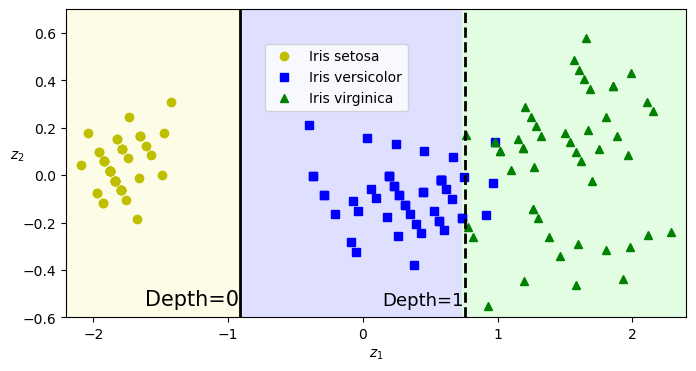

In [14]:
plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Depth=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Depth=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))

plt.show()

Cross-validation scores: [1.         1.         0.93333333 0.96666667 1.        ]
Mean cross-validation score: 0.9800000000000001
Confusion Matrix:
 [[50  0  0]
 [ 0 47  3]
 [ 0  0 50]]


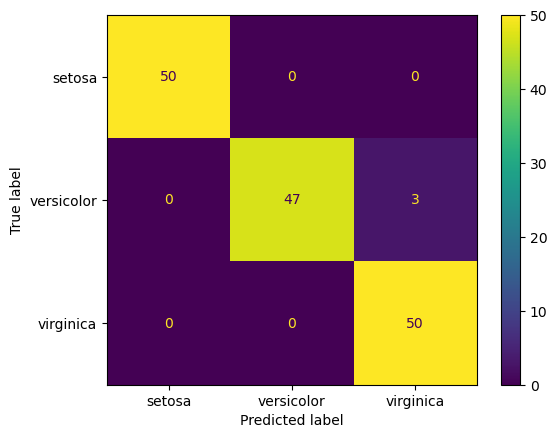

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       1.00      0.94      0.97        50
   virginica       0.94      1.00      0.97        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



In [15]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Perform cross-validation
scores = cross_val_score(tree_clf_pca, X_iris_rotated, y_iris, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

# Predict using cross-validation
y_pred = cross_val_predict(tree_clf_pca, X_iris_rotated, y_iris, cv=5)

# Confusion Matrix
conf_matrix = confusion_matrix(y_iris, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=iris.target_names)
disp.plot()
plt.show()

# Classification Report
report = classification_report(y_iris, y_pred, target_names=iris.target_names)
print("Classification Report:\n", report)

Cross-validation scores: [0.93333333 0.96666667 0.9        0.86666667 1.        ]
Mean cross-validation score: 0.9333333333333332
Confusion Matrix:
 [[50  0  0]
 [ 0 45  5]
 [ 0  5 45]]


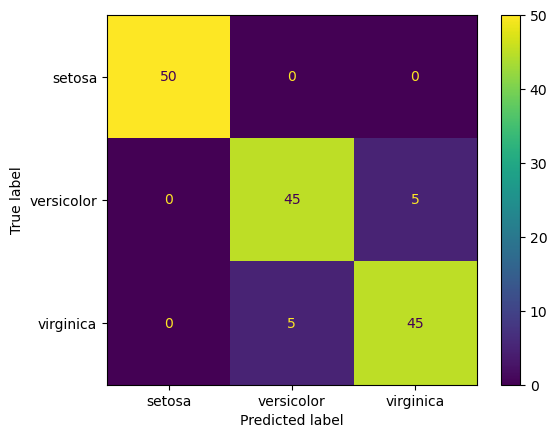

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.90      0.90      0.90        50
   virginica       0.90      0.90      0.90        50

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



In [16]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Perform cross-validation
scores = cross_val_score(tree_clf, X_iris, y_iris, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

# Predict using cross-validation
y_pred = cross_val_predict(tree_clf, X_iris, y_iris, cv=5)

# Confusion Matrix
conf_matrix = confusion_matrix(y_iris, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=iris.target_names)
disp.plot()
plt.show()

# Classification Report
report = classification_report(y_iris, y_pred, target_names=iris.target_names)
print("Classification Report:\n", report)

**Make Moons**

In [40]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [41]:
from sklearn.model_selection import train_test_split, learning_curve

X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons,
                                                    test_size=0.2,
                                                    random_state=42)

In [42]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_leaf_nodes': list(range(2, 100)),
    'max_depth': list(range(1, 7)),
    'min_samples_split': [2, 3, 4]
}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42),
                              params,
                              cv=3)

grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]})

In [43]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=17, random_state=42)

In [44]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8595

In [45]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances,
                  random_state=42)

for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [46]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.805671

In [47]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [48]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

/var/folders/hx/cc0z6z_x155f7ttzj7trq78m0000gn/T/ipykernel_27509/2539803968.py:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)


In [49]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.873

Voting Classifier

In [50]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [51]:
voting_clf = VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                                          ('rf', RandomForestClassifier(random_state=42)),
                                          ('svc', SVC(random_state=42))])
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [52]:
for name, clf in voting_clf.named_estimators_.items(): 
  print(name, "=", clf.score(X_test, y_test))

lr = 0.8415
rf = 0.8505
svc = 0.874


In [53]:
y_pred = voting_clf.predict(X_test)
voting_clf.score(X_test, y_test)

0.869

In [54]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True 
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.8705

Bagging and Pasting

In [55]:
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier


bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

In [56]:
bag_clf.score(X_test, y_test)

0.874

In [57]:
past_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1, random_state=42, bootstrap=False)
past_clf.fit(X_train, y_train)
past_clf.score(X_test, y_test)


0.875

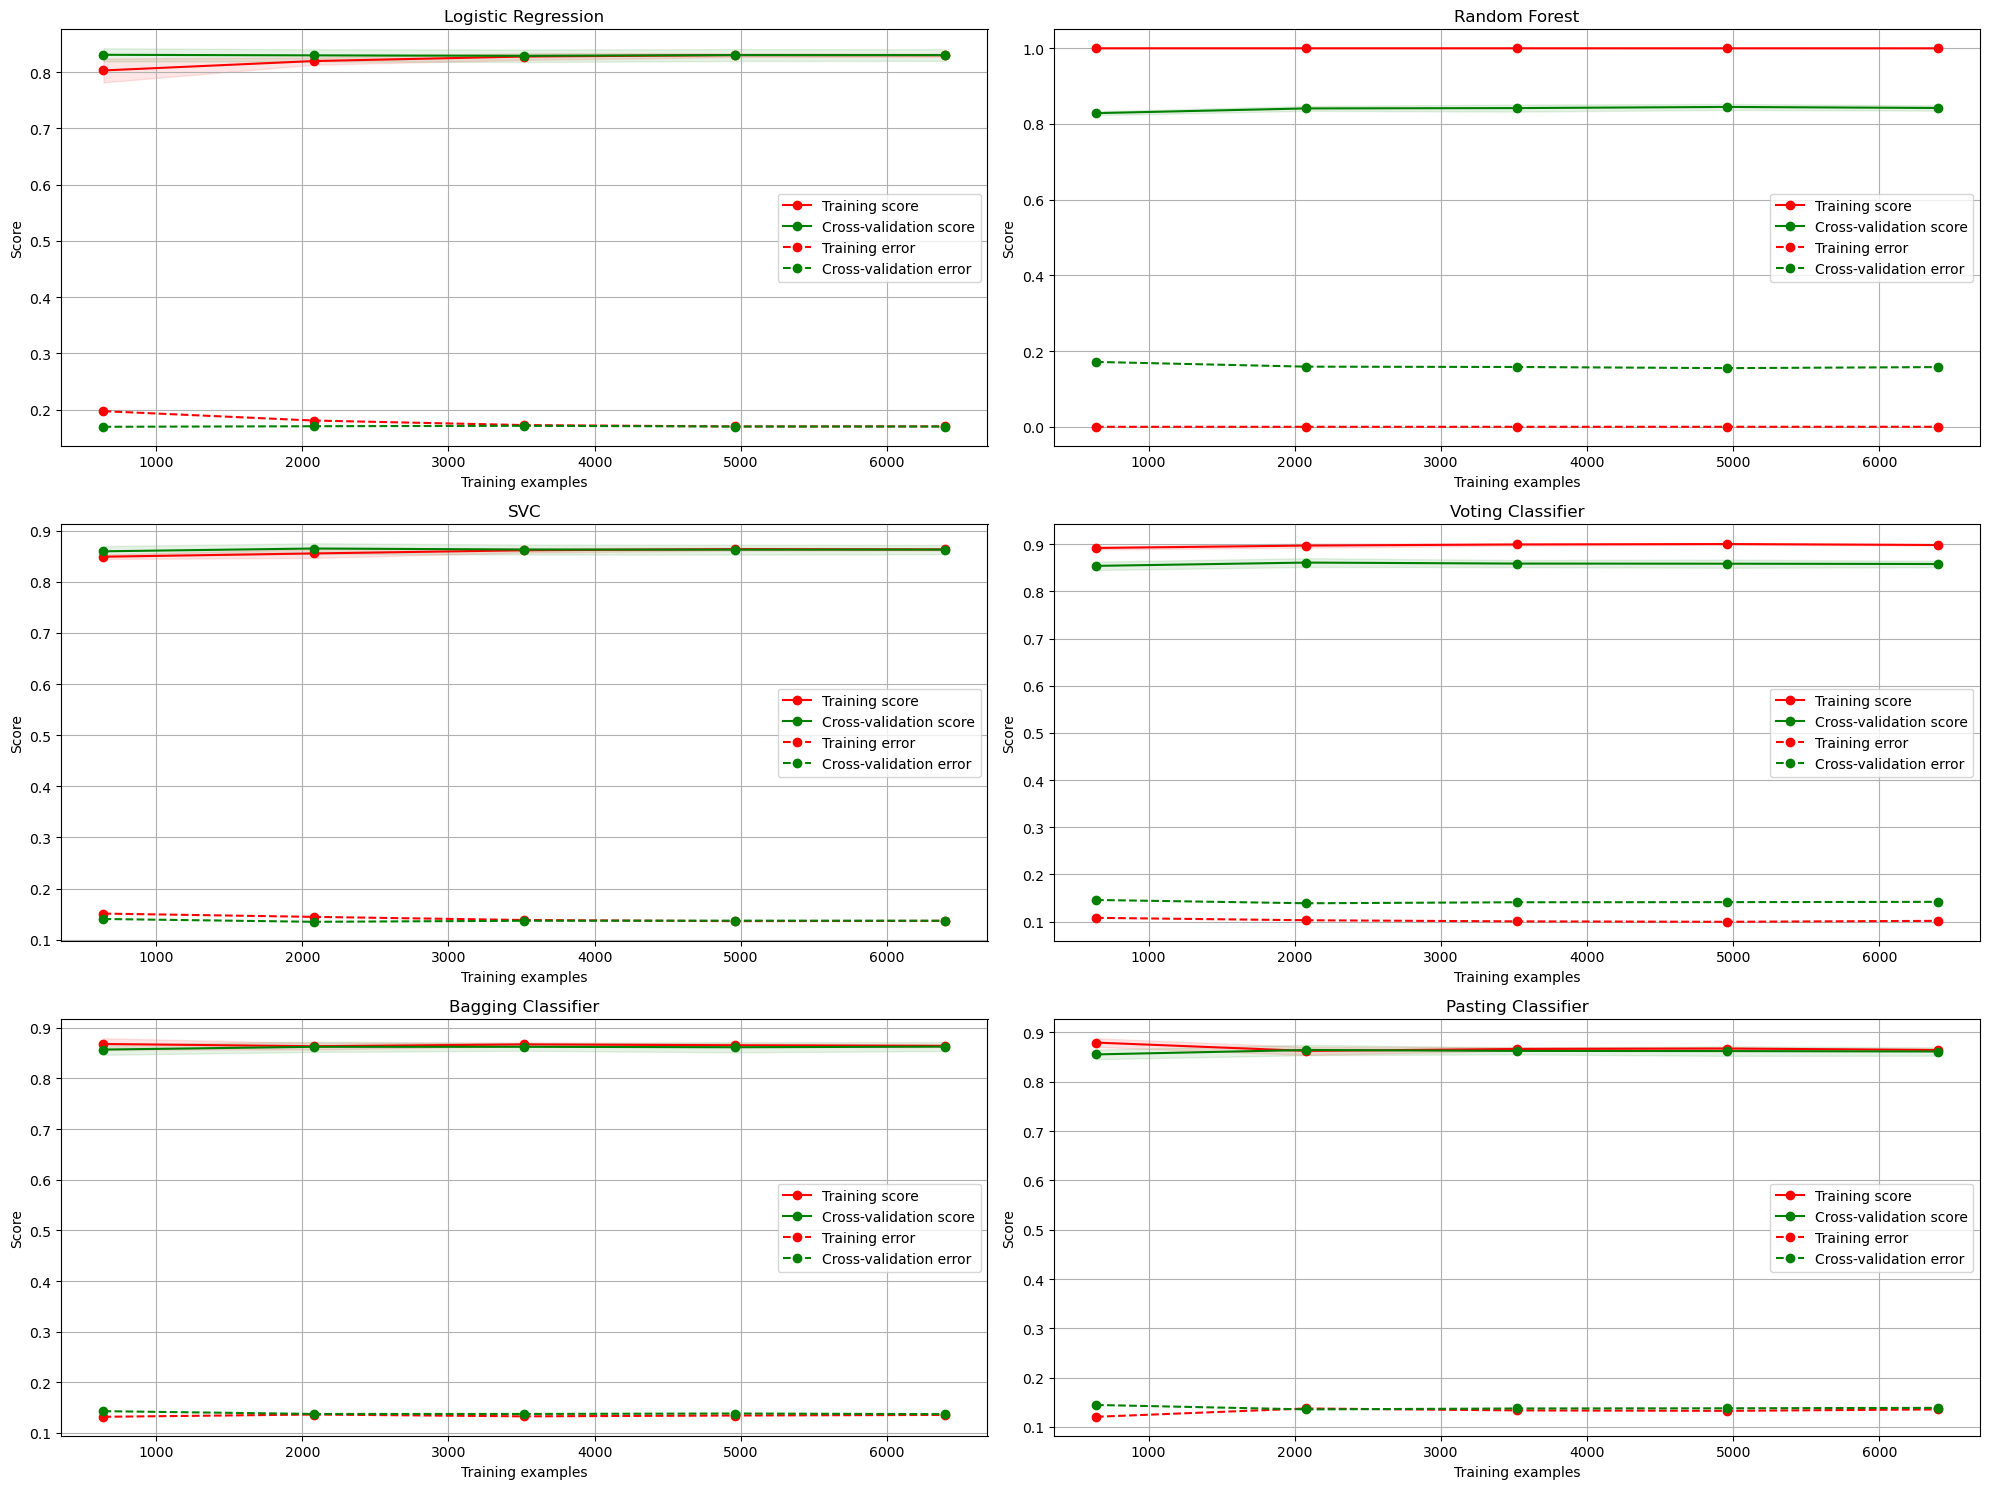

In [58]:
# Initialize classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVC": SVC(random_state=42),
    "Voting Classifier": voting_clf,
    "Bagging Classifier": bag_clf,
    "Pasting Classifier": past_clf
}

# Function to plot learning curves with error curves
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Calculate error curves
    train_errors_mean = 1 - train_scores_mean
    test_errors_mean = 1 - test_scores_mean

    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    # Plot error curves
    axes.plot(train_sizes, train_errors_mean, 'o--', color="r", label="Training error")
    axes.plot(train_sizes, test_errors_mean, 'o--', color="g", label="Cross-validation error")

    axes.legend(loc="best")
    return axes

# Example usage with classifiers dictionary
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.ravel()

for idx, (name, clf) in enumerate(classifiers.items()):
    plot_learning_curve(clf, name, X_train, y_train, axes=axes[idx], cv=5, n_jobs=-1)

plt.tight_layout()
plt.show()

RandomForestClassifier

In [59]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train) 
y_pred_rf = rnd_clf.predict(X_test)

In [61]:
rnd_clf.score(X_test, y_test)

0.871

Boosting

In [78]:
from sklearn.ensemble import AdaBoostClassifier


ada_clf = AdaBoostClassifier( DecisionTreeClassifier(max_depth=1), n_estimators=20, learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=20, random_state=42)

In [79]:
ada_clf.score(X_test, y_test)

0.8605

In [94]:
from sklearn.ensemble import GradientBoostingRegressor


gbrt = GradientBoostingRegressor(max_depth=4, n_estimators=20, learning_rate=0.2, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=4, n_estimators=20,
                          random_state=42)

In [95]:
gbrt.score(X_test, y_test)

0.6310229719674376

In [96]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier( 
  estimators=[
    ('lr', LogisticRegression(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)), 
    ('svc', SVC(probability=True, random_state=42))
  ], 
  final_estimator=RandomForestClassifier(random_state=43),
  cv=5 # number of cross-validation folds 
)
stacking_clf.fit(X_train, y_train)


StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [97]:
stacking_clf.score(X_test, y_test)

0.862